# Summary Statistics Based on Moments test
Comparison  between statistics of HH and application of same operations on DAP cell model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as spstats

In [2]:
from dap import DAPcython
from dap.utils import obs_params, obs_params_gbar, syn_current

In [3]:
# define sumstats parameters
n_mom = 5
n_xcorr = 4

## DAP model

In [4]:
dt = 0.01
params, labels = obs_params_gbar(reduced_model=True)
I, time, t_on, t_off = syn_current(duration=120, dt=0.01)

In [5]:
time

array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
       1.2000e+02])

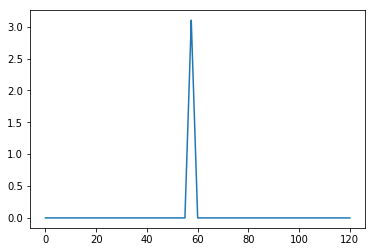

In [6]:
plt.plot(time, I);

In [7]:
params  = params

In [8]:
# define models / check setters
dap = DAPcython(-75, params)

In [9]:
# run models
data = dap.simulate(0.01, time, I)

In [10]:
dap_res =  {'data': data.reshape(-1),
        'time': time,
        'dt': dt,
        'I': I}

In [11]:
dap_res['data']

array([-75.        , -74.98903194, -74.98985763, ..., -77.48993582,
       -77.48905418, -77.48344873])

In [12]:
x = dap_res
t = dap_res['time']

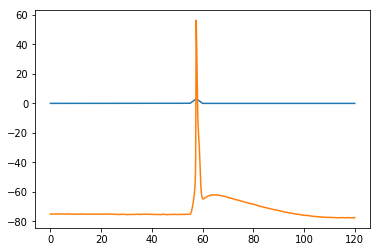

In [14]:
plt.plot(time, I)
plt.plot(time, data);

### Summary Statistics Moments

In [15]:
N = x['data'].shape[0]
t = x['time']
dt = x['dt']

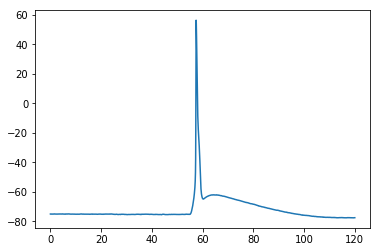

In [16]:
# initialise array of spike counts
v = np.array(x['data'])
plt.plot(t, v);

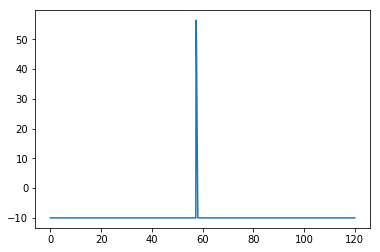

In [18]:
# put everything to -10 that is below -10 or has negative slope
ind = np.where(v < -10)
v[ind] = -10
plt.plot(t, v);

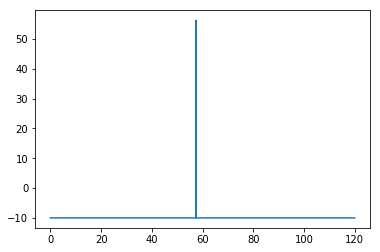

In [19]:
ind = np.where(np.diff(v) < 0)
v[ind] = -10
plt.plot(t, v);

In [20]:
# remaining negative slopes are at spike peaks
ind = np.where(np.diff(v) < 0)
spike_times = np.array(t)[ind]
spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]

In [21]:
# number of spikes
if spike_times_stim.shape[0] > 0:
    spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim))>0.5]

spike_times_stim

array([57.44])

### Resting potential

In [22]:
# resting potential and std
rest_pot = np.mean(x['data'][t<t_on])
rest_pot_std = np.std(x['data'][int(.9*t_on/dt):int(t_on/dt)])

# TODO: Find relevant lenght of the signal to analyse, not t_on, t_off

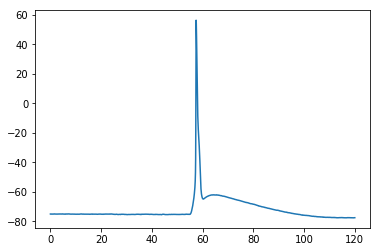

In [103]:
# initialise array of spike counts
v_all = np.array(x['data'])
plt.plot(t, v_all);

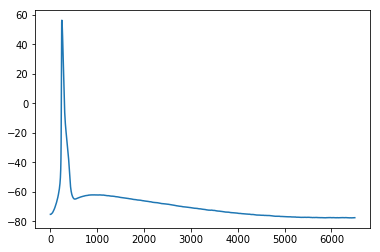

In [104]:
v_all = v_all[(t>t_on)]
plt.plot(v_all);

In [105]:
ind = np.where(v_all > rest_pot)

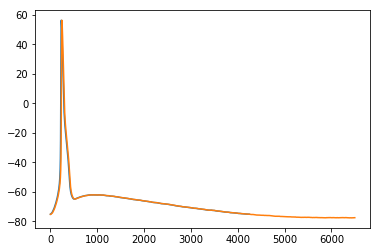

In [119]:
v2 = v_all[ind[0][0]:ind[0][-1]]
plt.plot(v2);
plt.plot(v_all);

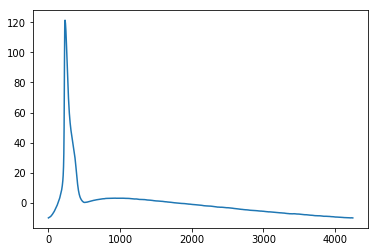

In [112]:
v_on_off = v2 - np.mean(v2)
plt.plot(v_on_off);

### Auto-correlation of the signal

In [113]:
# auto-correlations
# x_on_off = x['data'][(t > t_on) & (t < t_off)]-np.mean(x['data'][(t > t_on) & (t < t_off)])
x_on_off = v_on_off
x_corr_val = np.dot(x_on_off,x_on_off)


In [114]:
xcorr_steps = np.linspace(1./dt,n_xcorr*1./dt,n_xcorr).astype(int)
xcorr_steps

array([100, 200, 300, 400])

In [115]:
x_corr_full = np.zeros(n_xcorr)
x_corr_full

array([0., 0., 0., 0.])

In [116]:
for ii in range(n_xcorr):
    x_on_off_part = np.concatenate((x_on_off[xcorr_steps[ii]:],np.zeros(xcorr_steps[ii])))
    x_corr_full[ii] = np.dot(x_on_off,x_on_off_part)

x_corr1 = x_corr_full/x_corr_val
x_corr1

array([0.43121086, 0.06944967, 0.06947641, 0.10368107])

### Moments of the signal

In [129]:
v = v_on_off
v

array([-10.09293656, -10.06555415, -10.04580675, ..., -10.07724031,
       -10.09659964, -10.10265667])

In [130]:
std_pw = np.power(np.std(v), np.linspace(3,n_mom,n_mom-2))
std_pw

array([  3382.46356481,  50774.32628635, 762175.8994393 ])

In [131]:
std_pw = np.concatenate((np.ones(1),std_pw))
std_pw

array([1.00000000e+00, 3.38246356e+03, 5.07743263e+04, 7.62175899e+05])

In [132]:
moments = spstats.moment(v, np.linspace(2,n_mom,n_mom-1))/std_pw

In [146]:
np.linspace(2,n_mom,n_mom-1)

array([2., 3., 4., 5.])

In [133]:
moments

array([225.33159185,   5.1546554 ,  34.30694222, 239.46884828])

In [145]:
spstats.moment(v2, moment=[0,1,2,3,4])

array([1.00000000e+00, 0.00000000e+00, 2.25331592e+02, 1.74354341e+04,
       1.74191188e+06])

In [134]:
spstats.moment?


Signature: spstats.moment(a, moment=1, axis=0, nan_policy='propagate')
Docstring:
Calculate the nth moment about the mean for a sample.

A moment is a specific quantitative measure of the shape of a set of
points. It is often used to calculate coefficients of skewness and kurtosis
due to its close relationship with them.


Parameters
----------
a : array_like
   data
moment : int or array_like of ints, optional
   order of central moment that is returned. Default is 1.
axis : int or None, optional
   Axis along which the central moment is computed. Default is 0.
   If None, compute over the whole array `a`.
nan_policy : {'propagate', 'raise', 'omit'}, optional
    Defines how to handle when input contains nan. 'propagate' returns nan,
    'raise' throws an error, 'omit' performs the calculations ignoring nan
    values. Default is 'propagate'.

Returns
-------
n-th central moment : ndarray or float
   The appropriate moment along the given axis or over all values if axis
   is None. Th